In [1]:
import numpy as np
from numpy.random import Generator, PCG64, SeedSequence
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math as ma
from math import pi
import seaborn as sns
from scipy.special import gamma, logsumexp
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import numba as nb

# Bayesian fit and normalizing constant calculation of the exponential distribution

## Conjugate prior

The exponential distribution $\text{Exp}(\delta)$, the likelihood function associated to an iid sample  $x=(x_1,\ldots, x_n)$ is

$$
L(x|\delta)  = \delta^n\cdot e^{-\delta \sum_{i = 1}^n x_i},\text{ }x>0.
$$

Suppose that the prior distribution over $\delta$ is gamma $\text{Gamma}(a,1/b)$ with pdf

$$
\pi(\delta) = \frac{b^a\delta^{a-1}e^{-b\cdot \delta}}{\Gamma(a)}, \delta >0.
$$

The posterior distribution is then given by 

$$
\pi(\delta|x)=\frac{L(x|\delta)\pi(\delta)}{Z(x)} \sim \text{Gamma}\left(n+a, \frac{1}{b+ \sum_{i = 1}^n x_i} \right).
$$

The normalizing constant is equal to 

$$
Z(x) = \frac{b^a\Gamma(a+n)}{\Gamma(a)\left(b+\sum_{i = 1}^n x_i\right)^{a+n}}
$$

The following function sample from the posterior distribution. 


In [2]:
def sample_pos_δ(X, a, b, size):
    return(np.random.gamma(shape = len(X) + a, scale=1 / (b + sum(X)), size=size))

We illustrate the concentration of the posterior distribution arround the true value as the sample sizes increase from $10$ to $1000$.

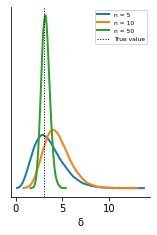

In [3]:
δ_true = 3
fig, axs = plt.subplots(1, 1, figsize=(2.5, 3.5))
for n in [5, 10, 50]:
    X, a, b, size = np.random.gamma(shape = 1, scale= 1 / δ_true, size=n), 0.1, 0.1, 50000
    δ_pos = sample_pos_δ(X, a, b, size)
    positions = np.linspace(min(δ_pos), max(δ_pos), 1000)
    kernel = st.gaussian_kde(δ_pos)
    plt.plot(positions, kernel(positions), lw=2, label = "n = "+str(n))
    
plt.axvline(x = δ_true, c = "black", lw=1, linestyle= "dotted", label = "True value")
plt.legend(fontsize = 6)


plt.yticks([])
plt.xlabel("δ")
sns.despine()
plt.savefig("../Figures/hist_post_sample_exponential_en.pdf")

## Metropolis Hasting random walk

We now apply the MH sampling scheme to sample from the posterior distribution. It requires the log ligelihood and also the log probability of the prior distribution 

In [4]:
def logp_exp(X):
    def logp(parms):
        λ = parms
        if λ>0:
            return(len(X) * np.log(λ) - np.sum(X) * λ)
        else: 
            return(-np.inf)
    return nb.jit(nopython=True)(logp)

# Log likelihood for the temperature search
def logp_exp_vect(X):
    def logp(parms):
        λ = parms
        return(len(X) * np.log(λ) - sum(X) * λ)
    return logp


# Log probability when the parameter is gamma distributed a priori 
def gamma_prior(a, b):
    def logp_prior(parms):
        λ = parms
        if λ>0:
            return((a - 1) * np.log(λ) - λ * b + a * np.log(b) - np.log(ma.gamma(a)))
        else:
            return(-np.inf)
    return nb.jit(nopython=True)(logp_prior)

# Function to generate the Markov chain trajectory
@nb.jit(nopython=True)
def MH_move_exp(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ):
    accepted = []
    λ = np.array([init_parms])
    for k in range(n_moves):
        noise = np.random.normal()
        λ_new = λ[-1] + step_size * noise  
        old_log_p = γ * log_prob(λ[-1]) + log_prob_prior(λ[-1])
        new_log_p = γ * log_prob(λ_new) + log_prob_prior(λ_new)
        acc =  new_log_p - old_log_p 

        if np.log(np.random.rand()) < acc:
            λ = np.append(λ, λ_new)
            accepted.append(True)
        else:
            λ =  np.append(λ, λ[-1])
            accepted.append(False)   
    return(λ[1:], accepted)

We sample value from the posterior distribution using Metropolis Hasting for different value of the scaling parameter $h$ parameters and return the trace plots.

CPU times: user 7.52 s, sys: 400 ms, total: 7.92 s
Wall time: 1.36 s
CPU times: user 556 ms, sys: 3.96 ms, total: 560 ms
Wall time: 560 ms
CPU times: user 630 ms, sys: 11.8 ms, total: 641 ms
Wall time: 641 ms


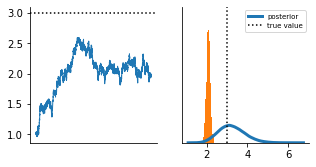

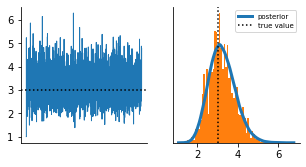

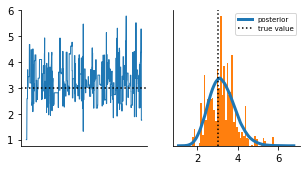

In [5]:
np.random.seed(123)
X, a, b = np.random.gamma(shape = 1, scale= 1 / δ_true, size = 25), 0.001, 0.001
δ_pos = sample_pos_δ(X, a, b, 100000)
positions = np.linspace(min(δ_pos), max(δ_pos), 1000)
kernel = st.gaussian_kde(δ_pos)
num_bins = 50
step_sizes = [0.01, 2.8, 30]
k = 0
for step_size in step_sizes:
    n_moves, log_prob, log_prob_prior, init_parms, γ = 10000, logp_exp(X), gamma_prior(a, b), 1.0, 1 
    %time trace, acc = MH_move_exp(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ)
    fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))
    axs[0].plot(trace, lw=1)
    axs[0].axhline(δ_true, color = "black", linestyle = "dotted")
    axs[0].set_xticks([])
    axs[1].plot(positions, kernel(positions), lw=3, label = "posterior")
    n, bins, patches = axs[1].hist(trace[5000:], num_bins, density=1)
    axs[1].axvline(δ_true, color = "black", linestyle = "dotted", label = "true value")
    axs[1].set_yticks([])

    axs[1].legend(fontsize = 7)
    sns.despine()
    plt.savefig("../Figures/trace_hist_exponential_"+str(k)+"_en.pdf")

    k+=1

## Sequential Monte Carlo

The SMC algorithm returns posterior samples and an estimation of the normalizing constant given by (in the exponential model considered)

In [6]:
def norm_constant(X, a, b):
    return(
        a*np.log(b)-(a + len(X)) * np.log(sum(X) + b) + sum(np.log([a+k for k in range(len(X))]))
           )

The SMC algorithm adapt sequentially the intermediary distribution by either increasing the temperature 

In [7]:
@nb.jit(nopython=True)
def temperature_search(λ, target, γ_prev, log_prob):
    popSize = len(λ)
    γ_up, γ_down = 2, γ_prev
    log_probs = np.array([log_prob(particle) for particle in λ]) 
    while γ_up - γ_down > 1e-6:
        γ_new = (γ_up + γ_down) / 2
        w =  np.exp(log_probs) ** (γ_new - γ_prev)
        if np.sum(w) == 0 or np.any(np.isnan(w)):
            W = 1 / popSize *np.ones(popSize)
            ESS = 0
        else:
            W = w / np.sum(w)
            ESS =  1 / np.sum(W**2)
        # print(γ_new, ESS)
        if ESS == target:
            break
        else:
            if ESS < target:
                γ_up = γ_new
            else:
                γ_down = γ_new
    if γ_new >= 1: 
        γ_new = 1

        w =  np.exp(log_probs) ** (γ_new - γ_prev)
        
        W = w / np.sum(w)
        ESS =  1 / np.sum(W**2)
    return(γ_new, w, W, int(ESS))

In [8]:
def smc_exp(popSize, a, b, log_prob, log_prob_prior, c, ρ, 
            n_step_max, paralell, n_proc):
    # popSize = number of particles
    # a,b = hyperparameter of the prior distribution on λ
    # c = probability that a particle is moved at least once
    # ρ = proportion of the sample of the ESS 
    # temp_step = size of the step in the search of the right temperature

    # The parameter is gamma distributed
    λ_prior = st.gamma(a)
    #  particles initialization
    print('sample generation 0')
    clouds = [pd.DataFrame({'λ': λ_prior.rvs(popSize) / b,
                          'w':np.ones(popSize)/ popSize,
                          'W': np.ones(popSize) / popSize
                          })]
    # Temperature sequence
    γ_seq = np.array([0])
    # Generation counter
    g=0
    
    # We keep on iterating until the temperature reaches 1
    while γ_seq[-1] < 1:
        # g, ESS, k = g + 1, 1, - err
        g = g + 1
        print('Sampling particles from generation ' + str(g))
        cloud = pd.DataFrame({ 'λ':[], 'w':[], 'W':[]})
        # Updating temperature sequence 
        γ, w, W, ESS = temperature_search(clouds[g-1]['λ'].values, 
                                              ρ * popSize, 
                                              γ_seq[-1], log_prob)
        
       
        γ_seq = np.append(γ_seq, γ)
                          
        # Updating unormalized weights
        cloud['w'] = w
        # Updating normalized weights
        cloud['W'] = W
       
        step_size = np.sqrt(np.cov(clouds[g-1]['λ'].values
                                   , aweights=W))*2.38
        particles = clouds[g-1]['λ'].values[np.random.choice(popSize,
                                                     popSize, p = W)]
        def move_particle_trial(particle):
            λ, accepted = MH_move_exp(1, step_size, 
                                      log_prob, log_prob_prior, particle, γ)
            return([λ[-1], np.mean(accepted)])
        
        if paralell:
            res = np.matrix(Parallel(n_jobs=n_proc)(delayed(move_particle_trial)(i) 
                                           for i in particles))
        else:
            res = np.matrix([move_particle_trial(particle) 
                             for particle in particles])
        
        λ_trial = np.asarray(res[:,0]).flatten()
        acc_rate = np.asarray(res[:,1]).flatten()
       
        n_steps = min(n_step_max,
                      max(2,np.ceil(np.log(1-c) / np.log(1-np.mean(acc_rate)))))
        
        print('Generation: ' + str(g) + " ;temperature: "+str(γ_seq[-1]) +
               " ;steps:" + str(n_steps) + " ;stepsize: "+str(step_size)+ 
               " ;ESS: "+str(ESS))
        def move_particle(particle):
            λ, accepted = MH_move_exp(int(n_steps), step_size, 
                                      log_prob, log_prob_prior, particle, γ)
            return([λ[-1], np.mean(accepted)])

        if paralell:
            res = np.matrix(Parallel(n_jobs=n_proc)(delayed(move_particle)(i) 
                                           for i in λ_trial))
        else:
             res = np.matrix([move_particle(particle) for particle in λ_trial])
        
        cloud['λ'] = np.asarray(res[:,0]).flatten()
        clouds.append(cloud)
    marginal_log_likelihood = sum(np.log(([cloud['w'].mean() 
                                            for cloud in clouds[1:g+1]])))
        
    return((clouds[-1].λ.values, marginal_log_likelihood))

In [9]:
popSize, a, b = 10000, 0.001, 0.001
log_prob, log_prob_prior =logp_exp(X), gamma_prior(a, b)
c, ρ, n_step_max = 0.99, 1/2, 25
paralell, n_proc = False, 4
# start = time.time()
%time trace, log_marg = smc_exp(popSize, a, b, log_prob, log_prob_prior, c, ρ, n_step_max, paralell, n_proc)
# print(f"Runtime of the program is {time.time() - start}")

sample generation 0
Sampling particles from generation 1
Generation: 1 ;temperature: 9.5367431640625e-07 ;steps:25 ;stepsize: 25.65766284748557 ;ESS: 318
Sampling particles from generation 2
Generation: 2 ;temperature: 0.00510024781260654 ;steps:25 ;stepsize: 19.039335872107042 ;ESS: 4999
Sampling particles from generation 3
Generation: 3 ;temperature: 0.02413365556822824 ;steps:18.0 ;stepsize: 9.6119211199505 ;ESS: 5000
Sampling particles from generation 4
Generation: 4 ;temperature: 0.1443060495415444 ;steps:9.0 ;stepsize: 4.02133522144172 ;ESS: 4999
Sampling particles from generation 5
Generation: 5 ;temperature: 1.0 ;steps:9.0 ;stepsize: 1.5301353790145498 ;ESS: 5041
CPU times: user 11.1 s, sys: 205 ms, total: 11.3 s
Wall time: 7.77 s


3.2347159953029982 -3.3420232045057277 -3.2769031384220355


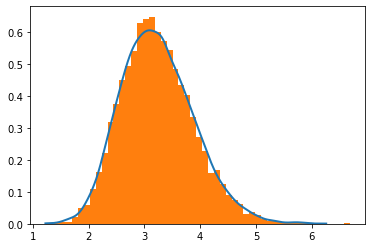

In [10]:
print(trace.mean(), log_marg, norm_constant(X, a, b))
δ_pos = sample_pos_δ(X, a, b, popSize)
positions = np.linspace(min(δ_pos), max(δ_pos), 1000)
kernel = st.gaussian_kde(δ_pos)
plt.plot(positions, kernel(positions), lw=2, label = "n = "+str(n))
n, bins, patches = plt.hist(trace, num_bins, density=1)

or the sample size

In [11]:
def batch_size_search(λ, target, n_prev, X):
    n_up, n_down = 2 * len(X), n_prev
    while n_up - n_down > 1:
        n_new = int(np.ceil((n_up + n_down) / 2))
        log_prob = logp_exp(X[n_prev:n_new])
        log_probs = np.array([log_prob(particle) for particle in λ]) 
#         log_prob = logp_exp_vect(X[n_prev:n_new])
        w =  np.exp(log_probs)
        
        if sum(w) == 0 or np.any(np.isnan(w)):
            W = 1 / popSize *np.ones(popSize)
            ESS = 0
        else:
            W = w / sum(w)
            ESS =  1 / sum(W**2)
        # print(γ_new, ESS)
        if ESS == target:
            break
        else:
            if ESS < target:
                n_up = n_new
            else:
                n_down = n_new
    if n_new >= len(X): 
        n_new = len(X)
        log_prob = logp_exp(X[n_prev:n_new])
        log_probs = np.array([log_prob(particle) for particle in λ]) 
        w =  np.exp(log_probs)
        W = w / sum(w)
        ESS =  1 / sum(W**2)
    return(n_new, w, W, int(ESS))     

In [12]:
def smc_exp_batch(popSize, a, b, X, log_prob_prior, c, ρ, n_step_max, 
                  paralell, n_proc):
    # popSize = number of particles
    # a,b = hyperparameter of the prior distribution on λ
    # c = probability that a particle is moved at least once
    # ρ = proportion of the sample of the ESS 
    # temp_step = size of the step in the search of the right temperature

    # The parameter is gamma distributed
    λ_prior = st.gamma(a)
    #  particles initialization
    print('sample generation 0')
    clouds = [pd.DataFrame({'λ': λ_prior.rvs(popSize) / b,
                          'w':np.ones(popSize)/ popSize,
                          'W': np.ones(popSize) / popSize
                          })]
    # Temperature sequence
    n_seq = np.array([0])
    # Generation counter
    g=0
    
    # We keep on iterating until the temperature reaches 1
    while n_seq[-1] < len(X):
        # g, ESS, k = g + 1, 1, - err
        g = g + 1
        print('Sampling particles from generation ' + str(g))
        cloud = pd.DataFrame({ 'λ':[], 'w':[], 'W':[]})
        # Updating temperature sequence 
        n, w, W, ESS = batch_size_search(clouds[g-1]['λ'].values,\
                                             ρ * popSize, n_seq[-1], X)
        
        n_seq = np.append(n_seq, n)
        # Updating unormalized weights
        cloud['w'] = w
        # Updating normalized weights
        cloud['W'] = W

        step_size = np.sqrt(np.cov(clouds[g-1]['λ'].values
                                   , aweights=W))*2.38
        particles = clouds[g-1]['λ'].values[np.random.choice(popSize,
                                                     popSize, p = W)]
        
        log_prob = logp_exp(X[0:n])
        def move_particle_trial(particle):
            λ, accepted = MH_move_exp(1, step_size, 
                                      log_prob, log_prob_prior, particle, 1)
            return([λ[-1], np.mean(accepted)])
        if paralell:
            
            res = np.matrix(Parallel(n_jobs=n_proc)(delayed(move_particle_trial)(i) 
                                           for i in particles))
            
        else:
           
            res = np.matrix([move_particle_trial(particle) 
                             for particle in particles])
            
            
        λ_trial = np.asarray(res[:,0]).flatten()
        acc_rate = np.asarray(res[:,1]).flatten()

        n_steps = min(n_step_max,
                      max(2,np.ceil(np.log(1-c) / np.log(1-np.mean(acc_rate)))))

        print('Generation: ' + str(g) + " ;batch size: "+str(n_seq[-1]) +
               " ;steps:" + str(n_steps) + " ;stepsize: "+str(step_size)+
               " ;ESS: "+str(ESS))
        def move_particle(particle):
            λ, accepted = MH_move_exp(int(n_steps), step_size, 
                                      log_prob, log_prob_prior, particle, 1)
            return([λ[-1], np.mean(accepted)])

        if paralell:
            res = np.matrix(Parallel(n_jobs=n_proc)(delayed(move_particle)(i) 
                                           for i in λ_trial))
        else:
             res = np.matrix([move_particle(particle) for particle in λ_trial])

        cloud['λ'] = np.asarray(res[:,0]).flatten()
        clouds.append(cloud)
    marginal_log_likelihood = sum(np.log(([cloud['w'].mean() 
                                            for cloud in clouds[1:g+1]])))

    return((clouds[-1].λ.values, marginal_log_likelihood))

In [14]:
popSize, a, b, log_prob_prior, c, ρ, n_step_max = 10000, 0.01, 0.01, gamma_prior(a, b), 0.99, 1/2, 25
paralell, n_proc = False, 4
# start = time.time()
%time trace, log_marg = smc_exp_batch(popSize, a, b,X, log_prob_prior, c, ρ, n_step_max, paralell, n_proc)
# print(f"Runtime of the program is {time.time() - start}")

sample generation 0
Sampling particles from generation 1
Generation: 1 ;batch size: 1 ;steps:13.0 ;stepsize: 5.589478242801715 ;ESS: 376
Sampling particles from generation 2
Generation: 2 ;batch size: 2 ;steps:10.0 ;stepsize: 6.519538150208986 ;ESS: 7026
Sampling particles from generation 3
Generation: 3 ;batch size: 12 ;steps:9.0 ;stepsize: 1.9948199812565381 ;ESS: 4954
Sampling particles from generation 4
Generation: 4 ;batch size: 25 ;steps:8.0 ;stepsize: 1.5343981638149462 ;ESS: 7720
CPU times: user 10.7 s, sys: 200 ms, total: 10.9 s
Wall time: 8.07 s


3.2228633810225933 -1.0043187878276192 -1.027048590416591


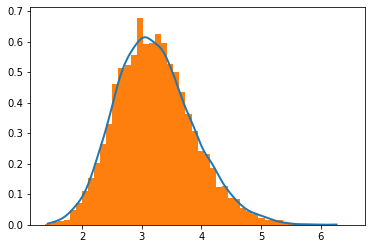

In [15]:
print(trace.mean(), log_marg, norm_constant(X, a, b))
δ_pos = sample_pos_δ(X, a, b, popSize)
positions = np.linspace(min(δ_pos), max(δ_pos), 1000)
kernel = st.gaussian_kde(δ_pos)
plt.plot(positions, kernel(positions), lw=2, label = "n = "+str(n))
n, bins, patches = plt.hist(trace, num_bins, density=1)

## Simulation study

In [19]:
np.random.seed(123)
# Data simulation
# iid sample of size 50 drawn the exponential distribution with parameter 1
δ_true, X = 3, np.random.gamma(shape = 1, scale= 1 / δ_true, size=50)
log_prob_vect, log_prob = logp_exp_vect(X), logp_exp(X)
# Gamma prior with parameter a and b
a, b, log_prob_prior = 0.1, 0.1, gamma_prior(a, b)
# SMC algorith setting
c, ρ, n_step_max,paralell, n_proc = 0.99, 1/2, 25, False, 1 
# Bridge sampling setting
r_init = 1

res_list = []
for popSize in [500, 2000, 5000]:
    print("Nombre de particules = " + str(popSize) )
    def compute_log_marg(i):
        trace, log_marg_like = smc_exp(popSize, a, b, log_prob, log_prob_prior, c, ρ, n_step_max, paralell, 
                                       n_proc)
#         smc_exp(popSize, a, b, log_prob_vect, log_prob, log_prob_prior, c, ρ, n_step_max, paralell, n_proc)
        trace, log_marg_data = smc_exp_batch(popSize, a, b, X, log_prob_prior, c, ρ, n_step_max, paralell, n_proc)
#         log_marg_bridge = bridge_log_normalizing_constant(X, a, b,log_prob, log_prob_prior, popSize, r_init)
        return(np.array([log_marg_like, log_marg_data]))
    %time res = np.array(Parallel(n_jobs=20)(delayed(compute_log_marg)(i) for i in range(100)))
    res_list.append(res)

Nombre de particules = 500
CPU times: user 1.16 s, sys: 25 ms, total: 1.18 s
Wall time: 29.2 s
Nombre de particules = 2000
CPU times: user 1.28 s, sys: 22.8 ms, total: 1.3 s
Wall time: 35.9 s
Nombre de particules = 5000
CPU times: user 1.44 s, sys: 37.6 ms, total: 1.48 s
Wall time: 56.4 s


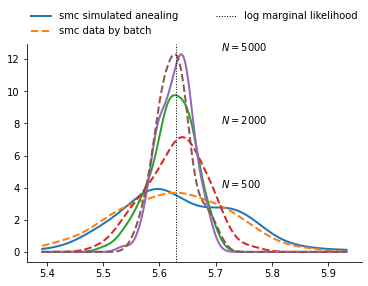

In [36]:
methods = ["smc simulated anealing", "smc data by batch"]
res = res_list[0]
positions = np.linspace(np.min(res), np.max(res), 1000)
linetypes = ["solid", "dashed"]
for k in range(2):
    kernel = st.gaussian_kde(np.asarray(res[:,k]))
    plt.plot(positions, kernel(positions), lw=2, label = methods[k], linestyle = linetypes[k])

for i in range(2):
    res = res_list[i+1]
    for k in range(2):
        kernel = st.gaussian_kde(np.asarray(res[:,k]))
        plt.plot(positions, kernel(positions), lw=2, linestyle = linetypes[k])
plt.axvline(x = norm_constant(X, a, b), c = "black", lw=1, linestyle= "dotted", label = "log marginal likelihood")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.,  frameon=False)
plt.text(5.71, 4,'$N = 500$', fontsize = 10)
plt.text(5.71, 8,'$N = 2000$', fontsize = 10)
plt.text(5.71, 12.5,'$N = 5000$', fontsize = 10)
sns.despine()
plt.savefig("../Figures/hist_exponential_normalizing_constant_en.pdf")
plt.show()

In [37]:
res = res_list[0]
stds = np.std(res, axis = 0)
for k in range(2):
    res = res_list[k+1]
    std_temp = np.std(res, axis = 0)
    stds = np.vstack((stds, std_temp))
df_std = pd.DataFrame(stds, index= ["N=500", "N=2000","N=5000"], columns= ["Simulated anealing", "Data by batch"])
print(df_std.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Simulated anealing &  Data by batch \\
\midrule
N=500  &            0.098432 &       0.095943 \\
N=2000 &            0.039133 &       0.053586 \\
N=5000 &            0.030312 &       0.031692 \\
\bottomrule
\end{tabular}

